In [ ]:
#Medición del tiempo de inicio
import time

# Registrar el tiempo actual en el momento del inicio
inicio = time.time()

In [ ]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import matplotlib as mpl
import seaborn as sns
from pandas.plotting import scatter_matrix
from tabulate import tabulate
import datetime as dt

# Machine learning packages
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Reducción de dimensiones
from sklearn.decomposition import PCA

# Regresión lineal
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Métricas de rendimiento
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score, mean_absolute_percentage_error
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import bartlett

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Pretty print
from pprint import pprint

#SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importar la clase MinMaxScaler de la biblioteca sklearn para realizar escalado en el rango [0, 1]
from sklearn.preprocessing import MinMaxScaler

# Importar la clase StandardScaler de la biblioteca sklearn para realizar escalamiento estándar
from sklearn.preprocessing import StandardScaler

# Importar la función tabulate del módulo tabulate para formatear tablas
from tabulate import tabulate

# Importar las clases y funciones necesarias de Keras para construir modelos de redes neuronales
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, BatchNormalization, ReLU
from keras import Model

# Importar el módulo joblib para guardar y cargar objetos de Python
import joblib


# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', '.*do not.*', )

# Mostrar advertencia personalizada
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [ ]:
def TrainingSets(data, dataξ, step_back):
    """
    Genera conjuntos de entrenamiento para un modelo de predicción basado en series de tiempo.

    Parámetros:
    - data (array-like): Datos de la serie de tiempo principal.
    - dataξ (array-like): Datos de la serie de tiempo exógena.
    - step_back (int): Número de pasos hacia atrás en el tiempo para cada muestra de entrenamiento.

    Retorna:
    - X_train (array): Conjunto de características de entrenamiento.
    - ξ_train (array): Conjunto de valores objetivo de entrenamiento correspondientes.

    Descripción:
    Esta función toma dos series de tiempo y un parámetro step_back para generar conjuntos de entrenamiento.
    Cada muestra de entrenamiento en X_train consiste en una secuencia de step_back puntos en la serie de tiempo
    principal, mientras que el valor correspondiente en la serie de tiempo exógena se almacena en ξ_train.
    """

    train_data = data.copy()
    train_dataξ = dataξ.copy()

    # Conjuntos de entrenamiento
    X_train, ξ_train = [], []

    for i in range(len(train_data) - step_back - 1):
        a = train_data[i:(i + step_back)]
        X_train.append(a)
        ξ_train.append(train_dataξ[i + step_back])

    X_train = np.array(X_train)
    ξ_train = np.array(ξ_train)

    return X_train, ξ_train

In [ ]:
def TrainingSet(sequence, n_steps):
    """
		Parámetros:
        sequence (numpy.ndarray): La secuencia univariante que se va a dividir.
        n_steps (int): El número de pasos temporales a considerar para cada muestra.

    Retorna:
        numpy.ndarray: Matriz de muestras de entrada, cada una con n_pasos de tiempo.
        numpy.ndarray: Matriz de muestras de salida, cada una correspondiente al siguiente paso temporal.

    Descripción:
		Esta función toma una secuencia univariante y la divide en pares de entrada-salida
    adecuados para la previsión de series temporales. Crea muestras de entrada deslizando una ventana
    de tamaño n_pasos sobre la secuencia, y para cada ventana, extrae n_pasos de tiempo como entrada y el siguiente paso de tiempo como salida.
    como entrada y el siguiente paso temporal como salida.
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

Carga Bases de Datos

In [ ]:
# Cargar datos de demanda energética comercial en Colombia desde Google Drive (acceso libre)

# Código de identificación del archivo en Google Drive
FILEID = "1feevcPPLWwZS2_ixxgKUoVi25NJQ0uJ_"  # Copiar el código desde el enlace generado en Google Drive

# Descargar el archivo utilizando wget y gestionar las cookies temporales
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O Departamentos.zip && rm -rf /tmp/cookies.txt

# Descomprimir el archivo descargado en el directorio principal de Colab
!unzip Departamentos.zip

# Mostrar el contenido del directorio actual
!dir

--2023-08-06 15:53:16--  https://docs.google.com/uc?export=download&confirm=&id=1feevcPPLWwZS2_ixxgKUoVi25NJQ0uJ_
Resolving docs.google.com (docs.google.com)... 74.125.142.101, 74.125.142.139, 74.125.142.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/40edet6hebro73bu14rb1umhj9m55og8/1691337150000/15940467605774616319/*/1feevcPPLWwZS2_ixxgKUoVi25NJQ0uJ_?e=download&uuid=7e84e2e4-151d-40ad-a0b5-ce0ef083ea26 [following]
--2023-08-06 15:53:22--  https://doc-0c-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/40edet6hebro73bu14rb1umhj9m55og8/1691337150000/15940467605774616319/*/1feevcPPLWwZS2_ixxgKUoVi25NJQ0uJ_?e=download&uuid=7e84e2e4-151d-40ad-a0b5-ce0ef083ea26
Resolving doc-0c-6k-docs.googleusercontent.com (doc-0c-6k-docs.googleusercontent.com)... 74.125.195.132, 2

In [ ]:
# Leer un archivo Excel y cargar los datos en un DataFrame 'df'
df = pd.read_excel('/content/Demanda_Arreglo_Mean.xlsx')

# Rellenar los valores faltantes en el DataFrame 'df' con el valor promedio de cada columna
df.fillna(df.mean(), inplace=True)

In [ ]:
# Cargar datos de demanda energética comercial en Colombia desde Google Drive (acceso libre)

# Código de identificación del archivo en Google Drive
FILEID = "1rOOEKQEFaA2SxrCFzr-jyJbDWkWbRcbe"  # Copiar el código desde el enlace generado en Google Drive

# Descargar el archivo utilizando wget y gestionar las cookies temporales
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O Modelos_ASO.zip && rm -rf /tmp/cookies.txt

# Descomprimir el archivo descargado en el directorio principal de Colab
!unzip Modelos_ASO.zip

# Mostrar el contenido del directorio actual
!dir

--2023-08-06 15:53:52--  https://docs.google.com/uc?export=download&confirm=&id=1rOOEKQEFaA2SxrCFzr-jyJbDWkWbRcbe
Resolving docs.google.com (docs.google.com)... 74.125.195.100, 74.125.195.102, 74.125.195.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ok186rpm5uhut1bjkth0uekm853nsca8/1691337225000/15940467605774616319/*/1rOOEKQEFaA2SxrCFzr-jyJbDWkWbRcbe?e=download&uuid=947ec61a-bfea-434c-8958-a6bca1d963ae [following]
--2023-08-06 15:53:52--  https://doc-0s-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ok186rpm5uhut1bjkth0uekm853nsca8/1691337225000/15940467605774616319/*/1rOOEKQEFaA2SxrCFzr-jyJbDWkWbRcbe?e=download&uuid=947ec61a-bfea-434c-8958-a6bca1d963ae
Resolving doc-0s-6k-docs.googleusercontent.com (doc-0s-6k-docs.googleusercontent.com)... 74.125.195.132, 2

In [ ]:
# Cargar un modelo previamente guardado desde un archivo .h5
model = tf.keras.models.load_model('/content/model_LSTM_M_18S.h5')

In [ ]:
# Eliminar la columna 'Date' del DataFrame 'df'
df = df.drop('Date', axis=1)

# Generar un rango de fechas desde '2020-10-01' hasta '2023-01-01' con una frecuencia horaria ('H')
date_rng = pd.date_range(start='2020-10-01', end='2023-01-01', freq='H')

# Establecer el índice del DataFrame 'df' con las fechas generadas
df.set_index(date_rng[0:-1], inplace=True)

In [ ]:
# Crear una copia del DataFrame 'df' en 'df1'
df1 = df.copy()

# Inicializar un objeto de la clase MinMaxScaler para el escalado
scaler = MinMaxScaler()

# Ajustar el escalador a los datos en 'df1'
scaler.fit(df1)

# Aplicar el escalado a los datos en 'df1'
df1 = scaler.transform(df1)

# Crear una copia de las columnas 1 en adelante como el conjunto de datos 'Ts1'
Ts1 = df1[:, 1:].copy()

# Crear un array de la columna 0 como la salida 'out'
out = df1[:, 0]

# Imprimir el tamaño de la serie horaria 'Ts1'
print('Tamaño Serie Horaria: ', Ts1.shape)

# Imprimir el tamaño de la serie de salida 'out'
print('Tamaño Serie Salida: ', out.shape)

Tamaño Serie Horaria:  (19728, 24)
Tamaño Serie Salida:  (19728,)


# TS= 18

In [ ]:
# Definición del número de pasos temporales en el pasado para construir secuencias
step_back = 18

# Crear conjuntos de entrenamiento (X1) y etiquetas (Y1) utilizando la función 'TrainingSets'
X1, Y1 = TrainingSets(data=Ts1, dataξ=out, step_back=step_back)

# Proporción de partición entre conjuntos de entrenamiento y prueba
Part = 0.8

# Particionar los conjuntos de entrenamiento y prueba para la serie 1
X_train = X1[:15781]  # Conjunto de entrenamiento
X_Val = X1[15781:16570]  # Conjunto de validación
X_test = X1[16570:]  # Conjunto de prueba

Y_train = Y1[:15781]  # Etiquetas del conjunto de entrenamiento
Y_Val = Y1[15781:16570]  # Etiquetas del conjunto de validación
Y_test = Y1[16570:]  # Etiquetas del conjunto de prueba

In [ ]:
# Imprimir los tamaños de los conjuntos de entrenamiento y prueba

# Imprimir el tamaño de X_train y Y_train
print('Tamaño X_train:', X_train.shape, 'Tamaño Y_train:', Y_train.shape)

# Imprimir el tamaño de X_test y Y_test
print('Tamaño X_test:', X_test.shape, 'Tamaño Y_test:', Y_test.shape)

# Imprimir una línea de separación
print('-----------------------------------------------------------------------')

Tamaño X_train:  (15781, 18, 24) Tamaño Y_train:  (15781,)
Tamaño X_val:  (789, 18, 24) Tamaño Y_val:  (789,)
Tamaño X_test:  (3139, 18, 24) Tamaño Y_test:  (3139,)
-----------------------------------------------------------------------


In [ ]:
# Mostrar el tipo de objeto del modelo
type(model)

keras.engine.sequential.Sequential

In [ ]:
# Utilizar el modelo para hacer predicciones en el conjunto de prueba (X_test)
y_predict = model.predict(X_test)

99/99 [==============================] - 4s 25ms/step


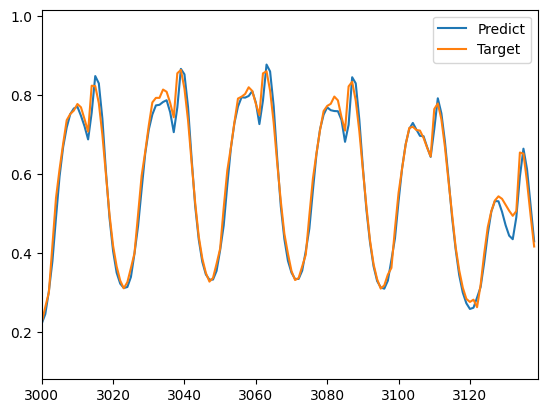

In [ ]:
# Graficar las predicciones y los valores reales del conjunto de prueba

# Graficar las predicciones
plt.plot(y_predict, label='Predicción')

# Graficar los valores reales (objetivos)
plt.plot(Y_test, label='Objetivo')

# Establecer límites en el eje x para mejorar la visualización
plt.xlim(3000, len(Y_test))

# Mostrar la leyenda en la gráfica
plt.legend()

# Mostrar la gráfica
plt.show()

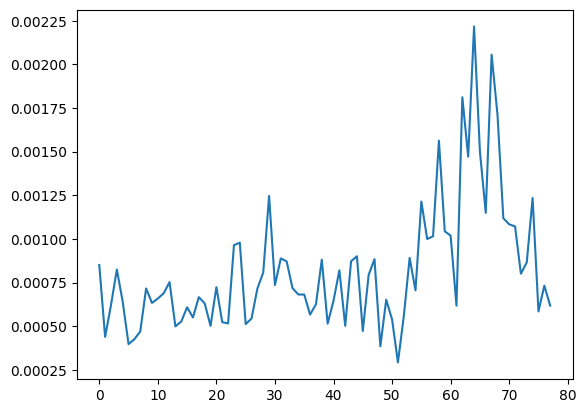

In [ ]:
# Definir las dos series de tiempo que serán comparadas
series1 = Y_test.copy()
series2 = y_predict.copy()

# Calcular la cantidad total de muestras
total_samples = len(series1)

# Definir el tamaño de los grupos para calcular el MSE por grupos
group_size = 40

# Calcular la cantidad total de grupos
num_groups = total_samples // group_size

# Redimensionar las series de tiempo dividiéndolas en grupos de 'group_size' muestras
series1_groups = np.array_split(series1, num_groups)
series2_groups = np.array_split(series2, num_groups)

# Calcular el MSE por grupos utilizando la métrica de error cuadrático medio
mse_by_groups = [mean_squared_error(s1, s2) for s1, s2 in zip(series1_groups, series2_groups)]

# Graficar los valores de MSE por grupo
plt.plot(mse_by_groups)
plt.xlabel('Grupos')
plt.ylabel('MSE')
plt.title('MSE por Grupos')
plt.show()

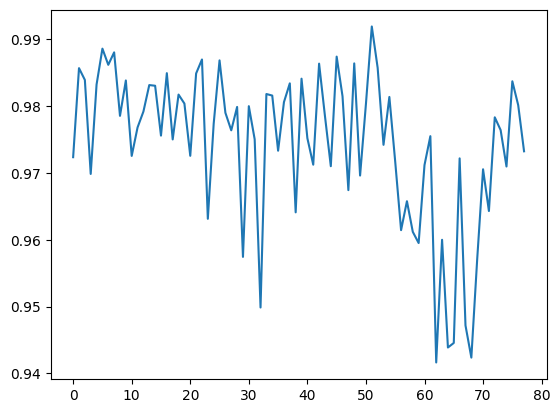

In [ ]:
# Definir las dos series de tiempo que serán comparadas
series1 = Y_test.copy()
series2 = y_predict.copy()

# Calcular la cantidad total de muestras
total_samples = len(series1)

# Definir el tamaño de los grupos para calcular el R2 por grupos
group_size = 40

# Calcular la cantidad total de grupos
num_groups = total_samples // group_size

# Redimensionar las series de tiempo dividiéndolas en grupos de 'group_size' muestras
series1_groups = np.array_split(series1, num_groups)
series2_groups = np.array_split(series2, num_groups)

# Calcular el R2 por grupos utilizando la métrica R2 (coeficiente de determinación)
r2_by_groups = [r2_score(s1, s2) for s1, s2 in zip(series1_groups, series2_groups)]

# Graficar los valores de R2 por grupo
plt.plot(r2_by_groups)
plt.xlabel('Grupos')
plt.ylabel('R2')
plt.title('R2 por Grupos')
plt.show()

In [ ]:
def FcnMAPE(S1, S2):
    """
    Parámetros:
        S1 (array-like): Serie de tiempo 1.
        S2 (array-like): Serie de tiempo 2.

    Retorna:
        float: Complemento de Symmetric Mean Absolute Percentage Error (cnSMAPE).

    Descripción:
        Calcula el Complemento de Symmetric Mean Absolute Percentage Error (cnSMAPE) entre dos series de tiempo.
    """
    mape = mean_absolute_percentage_error(S1, S2)  # Cálculo del MAPE
    smape = 2 * mape * 100 / (100 - mape)  # Cálculo del SMAPE
    cnSMAPE = round(1 - (smape / 2), 5)  # Cálculo del cnSMAPE
    return cnSMAPE

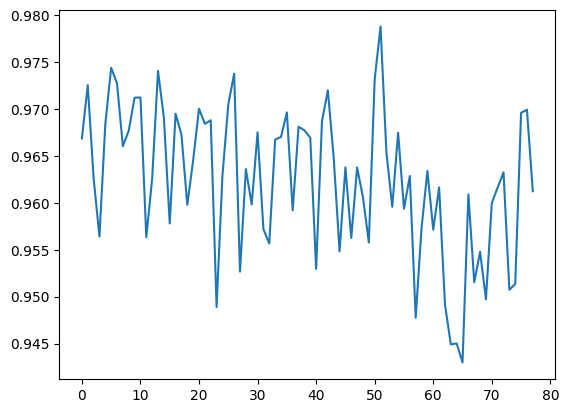

In [ ]:
# Definir las dos series de tiempo que serán comparadas
series1 = Y_test.copy()
series2 = y_predict.copy()

# Calcular la cantidad total de muestras
total_samples = len(series1)

# Definir el tamaño de los grupos para calcular el cnSMAPE por grupos
group_size = 40

# Calcular la cantidad total de grupos
num_groups = total_samples // group_size

# Redimensionar las series de tiempo dividiéndolas en grupos de 'group_size' muestras
series1_groups = np.array_split(series1, num_groups)
series2_groups = np.array_split(series2, num_groups)

# Calcular el cnSMAPE por grupos utilizando la función FcnMAPE
FcnMAPE_by_groups = [FcnMAPE(s1, s2) for s1, s2 in zip(series1_groups, series2_groups)]

# Graficar los valores de cnSMAPE por grupo
plt.plot(FcnMAPE_by_groups)
plt.xlabel('Grupos')
plt.ylabel('cnSMAPE')
plt.title('cnSMAPE por Grupos')
plt.show()

In [ ]:
# Supongamos que tienes las tres listas llamadas lista1, lista2 y lista3
# Aquí solo se proporcionan listas de ejemplo
lista1 = mse_by_groups.copy()
lista2 = r2_by_groups.copy()
lista3 = FcnMAPE_by_groups.copy()

# Crear un DataFrame utilizando las tres listas
data = {
    'MSE': lista1,
    'R2': lista2,
    'cnMAPE': lista3
}
df = pd.DataFrame(data)

# Definir el nombre del archivo Excel en el que se guardará el DataFrame
nombre_archivo = 'LSTM_M_18_SCORE.xlsx'

# Guardar el DataFrame en un archivo de Excel sin incluir los índices
df.to_excel(nombre_archivo, index=False)

# Imprimir mensaje para indicar que los datos se han guardado en el archivo
print("Datos combinados guardados en el archivo:", nombre_archivo)

Datos combinados guardados en el archivo: LSTM_M_18_SCORE.xlsx
